In [4]:
import sys
import numpy as np
import holidays
sys.path.append('../') 
from model import data_preparation as prep
import time

# Get Some Data

In [5]:
con = prep.create_connection()
t = time.time()
data = prep.prepare_data_2(con,20)
print(time.time()-t)

18.063724994659424


# Arrange Data to have List of training instances

In [6]:
print(data)

        ln_price          time_stamp  is_vacation  is_holiday  day_of_week  \
0       7.243513 2015-01-01 00:00:00            1           1            4   
1       7.243513 2015-01-01 01:00:00            1           1            4   
2       7.243513 2015-01-01 02:00:00            1           1            4   
3       7.243513 2015-01-01 03:00:00            1           1            4   
4       7.243513 2015-01-01 04:00:00            1           1            4   
5       7.243513 2015-01-01 05:00:00            1           1            4   
6       7.207119 2015-01-01 06:00:00            1           1            4   
7       7.207119 2015-01-01 07:00:00            1           1            4   
8       7.207119 2015-01-01 08:00:00            1           1            4   
9       7.207119 2015-01-01 09:00:00            1           1            4   
10      7.207119 2015-01-01 10:00:00            1           1            4   
11      7.207119 2015-01-01 11:00:00            1           1   

In [29]:
x_train_adjusted = np.array([x_train_adjusted[k] for k in sorted(x_train_adjusted.keys())])
x_train_adjusted = x_train_adjusted.reshape(-1,12)
x_test_adjusted = np.array([x_test_adjusted[k] for k in sorted(x_test_adjusted.keys())])
x_test_adjusted = x_test_adjusted.reshape(-1,12)
y_test_adjusted = np.array([y_test_adjusted[k] for k in sorted(y_test_adjusted.keys())])
y_test_adjusted = y_test_adjusted.reshape(-1,1)
y_train_adjusted = np.array([y_train_adjusted[k] for k in sorted(y_train_adjusted.keys())])
y_train_adjusted = y_train_adjusted.reshape(-1,1)


# normalize price MinMax

In [30]:
maxValue =y_train_adjusted[:,0].max()
x_train_adjusted = x_train_adjusted.astype(float)
x_test_adjusted = x_test_adjusted.astype(float)
x_train_adjusted[:,0] *=1/maxValue
x_test_adjusted[:,0] *=1/maxValue
y_test_adjusted[:,0] *=1/maxValue
y_train_adjusted[:,0] *=1/maxValue

In [31]:
x_train_adjusted[0]

array([  9.45951558e-01,   1.42007040e+18,   1.00000000e+00,
         1.00000000e+00,   4.00000000e+00,   4.47000000e+02,
        -5.25154027e+18,   1.50000000e+01,   1.05500000e+03,
        -1.00000000e+00,  -1.00000000e+00,  -2.00000000e+00])

In [32]:
x_train_adjusted = np.array(x_train_adjusted)
x_test_adjusted = np.array(x_test_adjusted)
#x_train_adjusted = x_train_adjusted.reshape(x_train_adjusted.shape + (1, ))
#x_test_adjusted = x_test_adjusted.reshape(x_test_adjusted.shape + (1, ))

# fitting lasso regression model

seems to fit best our problem with a penalty value of 1e^-6

0.766719038257


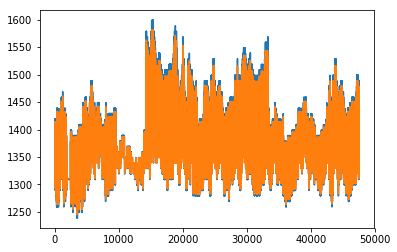

In [33]:
from sklearn import linear_model
import matplotlib.pyplot as plt
clf = linear_model.LassoLars(0.0000001)
clf.fit (x_train_adjusted, y_train_adjusted)
print(clf.score(x_test_adjusted , y_test_adjusted))

plt.plot(np.exp(y_test_adjusted*maxValue))
plt.plot(np.exp(clf.predict(x_test_adjusted)*maxValue))
plt.show()

In [34]:
x_test_adjusted

array([[  9.51112724e-01,   1.48856760e+18,   0.00000000e+00, ...,
         -1.00000000e+00,  -1.00000000e+00,  -2.00000000e+00],
       [  9.51112724e-01,   1.48857120e+18,   0.00000000e+00, ...,
         -1.00000000e+00,  -1.00000000e+00,  -2.00000000e+00],
       [  9.51112724e-01,   1.48857480e+18,   0.00000000e+00, ...,
         -1.00000000e+00,  -1.00000000e+00,  -2.00000000e+00],
       ..., 
       [  9.55101647e-01,   1.50567840e+18,   0.00000000e+00, ...,
         -2.00000000e+00,  -1.00000000e+00,  -2.00000000e+00],
       [  9.55101647e-01,   1.50568200e+18,   0.00000000e+00, ...,
         -2.00000000e+00,  -1.00000000e+00,  -2.00000000e+00],
       [  9.55101647e-01,   1.50568560e+18,   0.00000000e+00, ...,
         -2.00000000e+00,  -1.00000000e+00,  -2.00000000e+00]])

In [35]:

from sklearn.metrics import mean_squared_error
mean_squared_error(np.exp(y_test_adjusted*maxValue), np.exp(clf.predict(x_test_adjusted*maxValue)))

237213.00372908448